In [1]:
import sys
sys.path.append('/path/AL')

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, Dataset
import matplotlib.pyplot as plt
from AAE_model import AdversarialAutoEncoder

In [2]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.'
train_url = url + 'data'
test_url = url + 'test'

# Labels in the dataset
names = ["age","workclass","fnlwgt","education","education-num",
         "marital-status","occupation","relationship","race","sex",
         "capital-gain","capital-loss", "hours-per-week",
         "native-country","income>50k"]

# Download data
train_df = pd.read_csv(train_url, names = names, index_col = False, comment = '|')
test_df = pd.read_csv(test_url, names = names, index_col = False, comment = '|')

In [3]:
# Cleaning data and getting rid of symbols and 'None' values
train_df[train_df == '?'] = np.nan
train_df[train_df == ' ?'] = np.nan
train_df.dropna(inplace = True)

test_df[test_df == '?'] = np.nan
test_df[test_df == ' ?'] = np.nan
test_df.dropna(inplace = True)

In [4]:
# 'fnlwgt' is a counter for the number of repeated entries in the census, it has 0 correlation to 
# income so it can be discarded
# education-num is a numerical representation of education with a 1.0 correlation to education 
# so it is discarded as well

train_inputs = pd.get_dummies(train_df.drop(['income>50k', 'education-num', 'fnlwgt'], axis=1))
test_inputs = pd.get_dummies(test_df.drop(['income>50k', 'education-num', 'fnlwgt'], axis=1))

# Ensuring the dimensions are the same for the train and test sets
extra_columns = list(set(train_inputs.columns) - set(test_inputs.columns))
for c in extra_columns:
    test_inputs[c] = 0



# Creating labels from the dataset
train_labels, _ = train_df['income>50k'].factorize()
train_protected, _ = train_df['sex'].factorize() # male = 0, female = 1
test_labels, _ = test_df['income>50k'].factorize()
test_protected, _ = test_df['sex'].factorize() # male = 0, female = 1



# Convert input samples and target labels to tensors
# Also normalizing data to increase model performance
train_inputs = F.normalize(torch.Tensor(train_inputs.values))
train_labels = torch.Tensor(train_labels)
train_protected = torch.Tensor(train_protected)


test_inputs = F.normalize(torch.Tensor(test_inputs.values))
test_labels = torch.Tensor(test_labels)
test_protected = torch.Tensor(test_protected)


# Create a dataset object that pairs the input samples and target labels
train_dataset = TensorDataset(train_inputs, train_labels, train_protected)
test_dataset = TensorDataset(test_inputs, test_labels, test_protected)


# Dataloaders for training and testing
dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [5]:
# training settings
# input shape for Auto Encoder
INPUT_DIM = train_inputs.shape[1]
# layer size for AE
HIDDEN_DIM = 100
# Decode down size
ENCODED_DIM = 10
# Check if cuda processing is available
cuda = torch.cuda.is_available()

NUM_PARAM_TRIALS = 100
alpha = 0.05

parameters = set()
while len(parameters) < NUM_PARAM_TRIALS:
    beta = np.random.randint(1, 50)
    gamma = np.random.randint(1, 10)
    parameters.add((alpha, beta, gamma))

parameters = list(parameters)  

epochs = 50

In [6]:
# Training the model across different hyperparameters to 
# compare performance in different metrics and to optimize y_disc
#


# Log to store results for each set of parameters
log = np.zeros((NUM_PARAM_TRIALS,5))
delta_scores = np.zeros((NUM_PARAM_TRIALS,7))
# Counter to update which log entry
i = 0 
for params in parameters:
    model = AdversarialAutoEncoder(INPUT_DIM, HIDDEN_DIM, ENCODED_DIM,
                                   params[0],params[1],params[2])

    model.train_model(epochs, dataloader)
    deltas, results = model.evaluate_model(testloader)
    
    # Store different deltas for different values of t
    print(deltas)
    delta_scores[i][:] = [deltas[t] for t in range(7)]
    # Other metrics: Y_acc, y_disc, and hyperparameters for the model
    log[i] = [results[0],results[1], params[0],params[1],params[2]]
    i+=1
    print(f'Finished Model: {i}')

[tensor(0.8299), tensor(0.8244), tensor(0.8188), tensor(0.8133), tensor(0.8077), tensor(0.8022), tensor(0.7966)]
Finished Model: 1
[tensor(0.8259), tensor(0.8094), tensor(0.7929), tensor(0.7765), tensor(0.7600), tensor(0.7435), tensor(0.7270)]
Finished Model: 2
[tensor(0.8222), tensor(0.7941), tensor(0.7660), tensor(0.7379), tensor(0.7097), tensor(0.6816), tensor(0.6535)]
Finished Model: 3
[tensor(0.8297), tensor(0.8183), tensor(0.8068), tensor(0.7954), tensor(0.7839), tensor(0.7724), tensor(0.7610)]
Finished Model: 4
[tensor(0.8177), tensor(0.7582), tensor(0.6987), tensor(0.6392), tensor(0.5798), tensor(0.5203), tensor(0.4608)]
Finished Model: 5
[tensor(0.8191), tensor(0.7673), tensor(0.7155), tensor(0.6637), tensor(0.6120), tensor(0.5602), tensor(0.5084)]
Finished Model: 6
[tensor(0.8333), tensor(0.8091), tensor(0.7849), tensor(0.7607), tensor(0.7365), tensor(0.7123), tensor(0.6882)]
Finished Model: 7
[tensor(0.8304), tensor(0.8222), tensor(0.8139), tensor(0.8057), tensor(0.7974), te

In [7]:
# Store results
np.savetxt('raw_results_log.txt', log, fmt = '%f', delimiter = ',')

In [8]:
# Selecting best models for each t-value
t_values = np.arange(0,3.5,0.5)
best_model = np.zeros((7,7))

for t in range(7):
    t_value = t_values[t]
    best_delta = np.argmax(delta_scores[:,t])
    best_delta_score = delta_scores[best_delta][t]
    log_data = log[best_delta]
    best_model[t][:] = [best_delta_score, # y_delta
                        log_data[0], # y_disc
                        log_data[1], # y_acc
                        t_value,  
                        log_data[2], # alpha 
                        log_data[3], # beta
                        log_data[4]] # gamma
    
np.savetxt('best_models.txt', best_model, fmt = '%.3f', delimiter = ',')

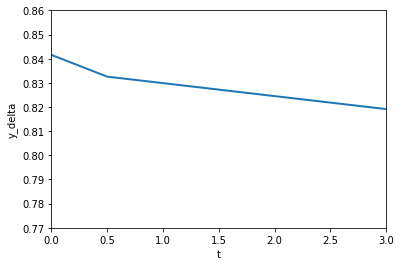

In [9]:
import matplotlib.pyplot as plt

y_axis = best_model[:,0]
x_axis = t_values

fig, ax = plt.subplots()

plt.rcParams['figure.figsize'] = [20, 5]
ax.plot(x_axis, y_axis, linewidth = 2.0)
plt.xlabel("t")
plt.ylabel('y_delta')
plt.ylim([0.77,0.86])
plt.xlim([0,3])


plt.savefig('y_delta across different t values.jpg')






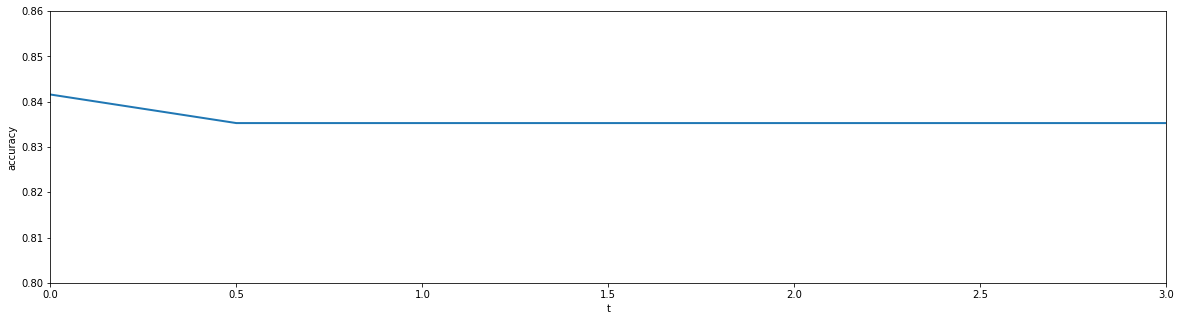

In [10]:
y_axis = best_model[:,2]
x_axis = t_values

fig, ax = plt.subplots()

plt.rcParams['figure.figsize'] = [20, 5]
ax.plot(x_axis, y_axis, linewidth = 2.0)
plt.xlabel("t")
plt.ylabel('accuracy')
plt.ylim([0.8,0.86])
plt.xlim([0,3])


plt.savefig('accuracy across different t values.jpg')

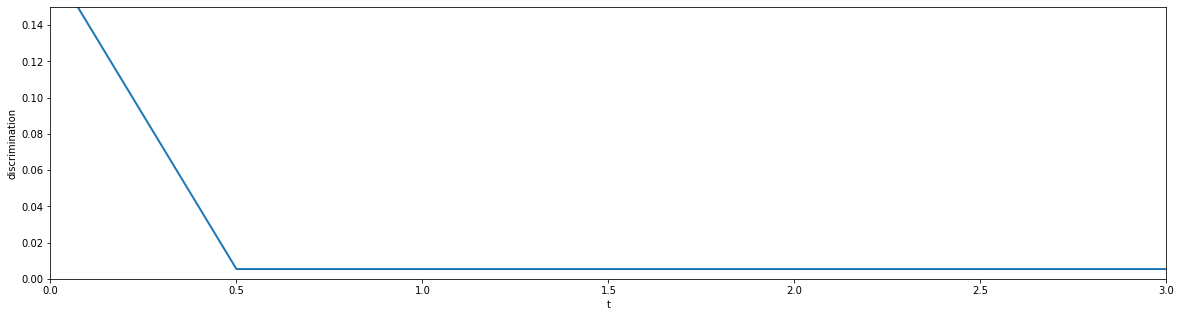

In [11]:
y_axis = best_model[:,1]
x_axis = t_values

fig, ax = plt.subplots()

plt.rcParams['figure.figsize'] = [20, 5]
ax.plot(x_axis, y_axis, linewidth = 2.0)
plt.xlabel("t")
plt.ylabel('discrimination')
plt.ylim([0,0.15])
plt.xlim([0,3])


plt.savefig('discrimination across different t values.jpg')

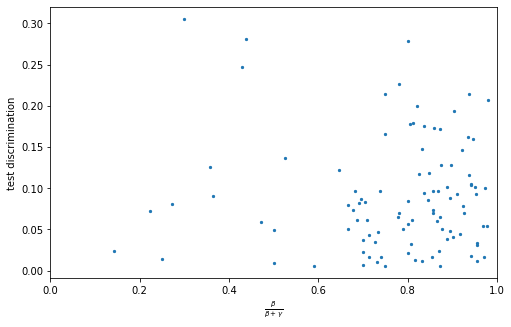

In [12]:
#0 disc, 3 beta, 4 gamma

b_ratio = [log[param,3]/(log[param,3]+log[param,4]) for param in range(len(log))]
test_disc = log[:,0]

plt.rcParams['figure.figsize'] = [8, 5]
plt.scatter(b_ratio, test_disc, s =5)
plt.xlim(0,1.0,0.2)
plt.xlabel(r'$\frac{\beta}{\beta + \gamma}$')
plt.ylabel('test discrimination')

plt.savefig('hyperparameter scatter plot disc.jpg')

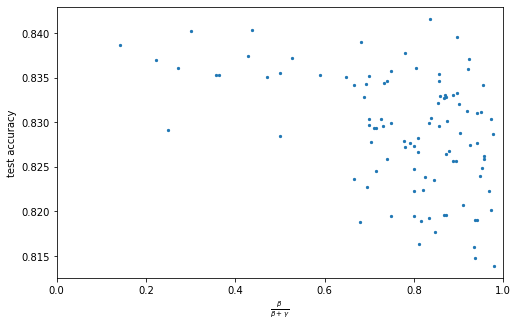

In [14]:
#0 disc, 3 beta, 4 gamma

b_ratio = [log[param,3]/(log[param,3]+log[param,4]) for param in range(len(log))]
test_acc = log[:,1]

plt.rcParams['figure.figsize'] = [8, 5]
plt.scatter(b_ratio, test_acc, s =5)
plt.xlim(0,1.0,0.2)
plt.xlabel(r'$\frac{\beta}{\beta + \gamma}$')
plt.ylabel('test accuracy')

plt.savefig('hyperparameter scatter plot acc.jpg')